# Init

CUDA Not Available


  0%|                                                                                           | 0/200 [00:00<?, ?it/s]/tmp/ipykernel_389953/1447923721.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(data.y.clone().detach(), dtype=torch.float)
/tmp/ipykernel_389953/1447923721.py:200: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(data.y.clone().detach(), dtype=torch.float)
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [09:38<00:00,  2.89s/it]


total time 9.647675176461538 min


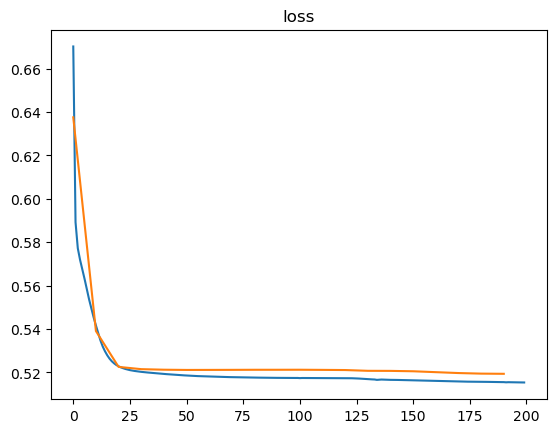

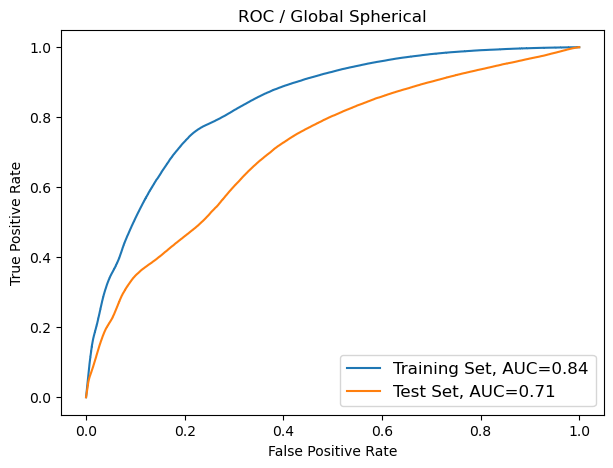

In [1]:
# One-Celler

import os
from time import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
import random


seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
np.random.seed(seed) # Numpy module.
random.seed(seed) # Python random module.
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True



# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')
# One liner:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Load Data & Graph
def load_data(i, f, local=False, spherical=True):
    dataset = []
    if not local: Xlist, ylist, edgelist = [], [], []
    
    for num in np.arange(i,f):
        df_sphere = pd.read_csv(f'/data1/dhhyun/DM100/df_DM{num:02}.csv', index_col=0)
        edge_index = np.genfromtxt(f'/data1/dhhyun/DM100/DM{num:02}_graph_k10.csv', delimiter=',', dtype='int')
        edge_index = torch.tensor(edge_index, dtype=torch.long)
        edge_index = edge_index.t().contiguous()

        if local:
            if spherical:
                X = np.column_stack((df_sphere['r'], df_sphere['theta'], df_sphere['phi'],
                    df_sphere['v_r'], df_sphere['v_theta'], df_sphere['v_phi']))
            else:
                X = np.column_stack((df_sphere['lx'], df_sphere['ly'], df_sphere['lz'],
                    df_sphere['vx'], df_sphere['vy'], df_sphere['vz']))
            y = np.array(df_sphere['flag']) # 1 for bound. #0 < #1
            
            # Normalization
            scaler = MinMaxScaler() # axis=0 default
            scaler.fit(X) 
            X = scaler.transform(X)
            
            # Data Object
            X = torch.tensor(X, dtype=torch.float)
            y = torch.tensor(y, dtype=torch.float) # not int32 #################### originally torch.long for class identification
            data = Data(x=X, edge_index=edge_index, y=y)
                        # train_mask=train_mask, test_mask=test_mask) # below
            dataset.append(data)
            
        elif not local:
            if spherical:
                X = np.column_stack((df_sphere['gr'], df_sphere['gtheta'], df_sphere['gphi'],
                    df_sphere['gv_r'], df_sphere['gv_theta'], df_sphere['gv_phi']))
            else:
                X = np.column_stack((df_sphere['x'], df_sphere['y'], df_sphere['z'],
                    df_sphere['vx'], df_sphere['vy'], df_sphere['vz']))
            y = np.array(df_sphere['flag']) # 1 for bound. #0 < #1
            Xlist.append(X)
            ylist.append(y)
            edgelist.append(edge_index)
            
    # Global Scaling
    if not local: 
        X_train = np.concatenate(Xlist[0::2], axis=0)
        X_test = np.concatenate(Xlist[1::2], axis=0)
        
        # Normalization
        scaler1 = MinMaxScaler() # axis=0 default
        scaler1.fit(X_train) 
        scaler2 = MinMaxScaler()
        scaler2.fit(X_test) 
        
        for index, (X, y, edge_index) in enumerate(zip(Xlist, ylist, edgelist)):
            if index%2==0:
                X = scaler1.transform(X)
            else:
                X = scaler2.transform(X)
                
            # Data Object
            X = torch.tensor(X, dtype=torch.float)
            y = torch.tensor(y, dtype=torch.float) # not int32 ### originally torch.long for class identification
            data = Data(x=X, edge_index=edge_index, y=y)
            dataset.append(data)
            
    return dataset[0::2], dataset[1::2] # training, test

train_dataset, test_dataset = load_data(0, 100, local=False, spherical=True)


# Train, Val, Test mask
# train_mask = np.zeros(len(y), dtype='int')
# num_samples = int(0.9 * len(y)) #later revise to be 8:1:1
# selected_indices = np.random.choice(train_mask, size=num_samples, replace=False)
# train_mask[selected_indices] = 1
# np.savetxt('/data1/dhhyun/train_mask.csv', train_mask, delimiter=',', fmt='%d')
# test_mask = torch.tensor(~train_mask, dtype=torch.bool)
# train_mask = torch.tensor(train_mask, dtype=torch.bool)

# trainloader = DataLoader(train_dataset, batch_size=1, shuffle=True) # batch_size=32


# GCN Layer
num_node_features = 6
num_hidden = 4

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, 6)
        self.conv2 = GCNConv(6, 4)
        self.conv3 = GCNConv(4, 1)
        # even number nodes are preferable

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # x = F.dropout(x, p=0.25, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        # x = F.dropout(x, training=self.training)
        
        x = self.conv3(x, edge_index)

        # return F.log_softmax(x, dim=1)
        
        m = torch.nn.Sigmoid()
        return m(x)


# Train
model = GCN().to(device)
# data = data.to(device)
criterion = torch.nn.BCELoss() ###############
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4) #####lr 0.01 -> 0.005
start = time()

loss_ = []
loss2_ = []
# n = len(trainloader) # for n batches
# n = 1

model.train()
for epoch in tqdm(range(200)):
    running_loss = 0.0
    n = len(train_dataset)
    
    for data in train_dataset: #trainloader:
        data = data.to(device) ###########################################################
        optimizer.zero_grad()
        out = model(data)
        # loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        ###############
        # out_T = out[data.train_mask].t()[0]
        # loss = criterion(out_T, data.y[data.train_mask]) ###############
        # out_T = out.t()[0]
        out_T = out.squeeze() ########
        y_true = torch.tensor(data.y.clone().detach(), dtype=torch.float)
        loss = criterion(out_T, y_true)
        ##############
        loss.backward()
        optimizer.step()

        running_loss += loss.item() # for the case using trainloader inside a for loop
    loss_.append(running_loss/n) # MSE(Mean Squared Error)
    if epoch % 10 ==0:
        # with torch.no_grad():
        running_loss = 0.0
        for data in test_dataset: #trainloader:
            n = len(test_dataset)
            data = data.to(device) 
            out = model(data)
            out_T = out.squeeze()
            y_true = torch.tensor(data.y.clone().detach(), dtype=torch.float)
            loss = criterion(out_T, y_true)
            running_loss += loss.item() 
        loss2_.append(running_loss/n) # MSE(Mean Squared Error)
        
    
t = (time()-start)
print('total time', f'{t/60} min' if t>60 else f'{t} sec')

# Export the result
# np.savetxt('/data1/dhhyun/DM100/loss_train.csv', loss_, delimiter=',')
# np.savetxt('/data1/dhhyun/DM100/loss_eval.csv', loss2_, delimiter=',')

# Visualization
plt.plot(np.arange(0,200,1), loss_)
plt.plot(np.arange(0,200,10), loss2_)
plt.title('loss')
plt.show()


pred_train_true = []
for d in train_dataset:
    pred_train_true.append(d.y.detach().numpy())
pred_train_true = np.concatenate(pred_train_true)

pred_test_true = []
for d in test_dataset:
    pred_test_true.append(d.y.detach().numpy())
pred_test_true = np.concatenate(pred_test_true)


# Evaluation
with torch.no_grad():
    model.eval()
    # pred = model(data).argmax(dim=1)

    predlist = []
    for data in train_dataset:
        pred = model(data) #####################
        predlist.append(pred.detach().numpy())
    pred_train = np.concatenate(predlist)

    predlist = []
    for data in test_dataset:
        pred = model(data) #####################
        predlist.append(pred.detach().numpy())
    pred_test = np.concatenate(predlist)

# Export
# pred_train_save = pred_train.cpu().detach().numpy()
# pred_test_save = pred_test.cpu().detach().numpy()
# np.savetxt('/data1/dhhyun/DM100/pred_train.csv', pred_train_save, delimiter=',', fmt='%d')
# np.savetxt('/data1/dhhyun/DM100/pred_test.csv', pred_test_save, delimiter=',', fmt='%d')


fpr1, tpr1, _ = roc_curve(pred_train_true, pred_train)
fpr2, tpr2, _ = roc_curve(pred_test_true, pred_test)

auc1 = roc_auc_score(pred_train_true, pred_train)
auc2 = roc_auc_score(pred_test_true, pred_test)
print('train', auc1, 'test', auc2)

fig, ax = plt.subplots(figsize=(7,5))#dpi=150)
RocCurveDisplay(fpr=fpr1, tpr=tpr1).plot(ax=ax, label=f'Training Set, AUC={auc1:.2f}')
RocCurveDisplay(fpr=fpr2, tpr=tpr2).plot(ax=ax, label=f'Test Set, AUC={auc2:.2f}')

plt.title('ROC / Global Spherical')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# ax.annotate(f'AUC (Training Set): {auc1:.2f}\nAUC (Test Set):      {auc2:.2f}', xy=(0.6,0.2), fontsize=12)
plt.legend(fontsize=12)
plt.show()

CUDA Not Available


  0%|                                                                                           | 0/200 [00:00<?, ?it/s]/tmp/ipykernel_400986/1447923721.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(data.y.clone().detach(), dtype=torch.float)
/tmp/ipykernel_400986/1447923721.py:200: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(data.y.clone().detach(), dtype=torch.float)
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:13<00:00,  3.07s/it]

total time 10.223115678628286 min


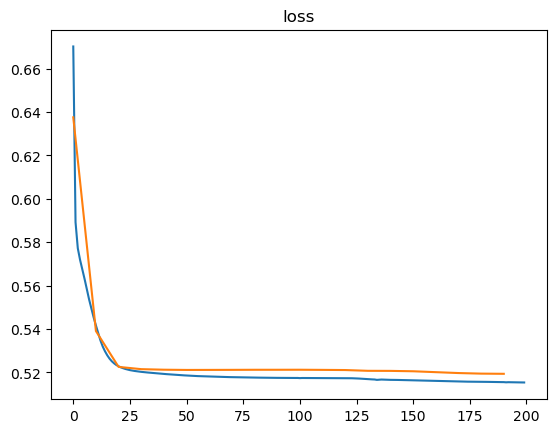

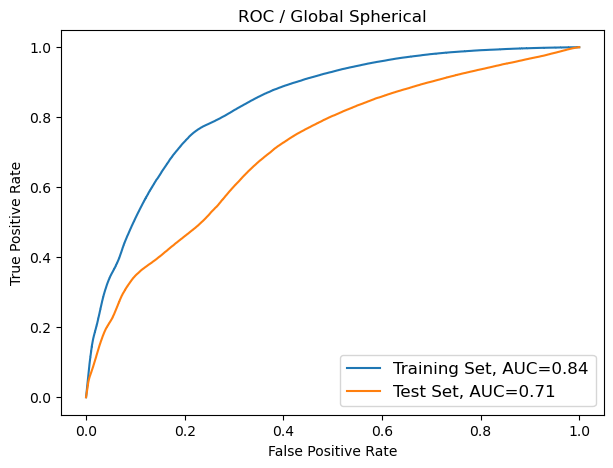

In [1]:
# One-Celler

import os
from time import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
import random


seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
np.random.seed(seed) # Numpy module.
random.seed(seed) # Python random module.
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True



# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')
# One liner:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Load Data & Graph
def load_data(i, f, local=False, spherical=True):
    dataset = []
    if not local: Xlist, ylist, edgelist = [], [], []
    
    for num in np.arange(i,f):
        df_sphere = pd.read_csv(f'/data1/dhhyun/DM100/df_DM{num:02}.csv', index_col=0)
        edge_index = np.genfromtxt(f'/data1/dhhyun/DM100/DM{num:02}_graph_k10.csv', delimiter=',', dtype='int')
        edge_index = torch.tensor(edge_index, dtype=torch.long)
        edge_index = edge_index.t().contiguous()

        if local:
            if spherical:
                X = np.column_stack((df_sphere['r'], df_sphere['theta'], df_sphere['phi'],
                    df_sphere['v_r'], df_sphere['v_theta'], df_sphere['v_phi']))
            else:
                X = np.column_stack((df_sphere['lx'], df_sphere['ly'], df_sphere['lz'],
                    df_sphere['vx'], df_sphere['vy'], df_sphere['vz']))
            y = np.array(df_sphere['flag']) # 1 for bound. #0 < #1
            
            # Normalization
            scaler = MinMaxScaler() # axis=0 default
            scaler.fit(X) 
            X = scaler.transform(X)
            
            # Data Object
            X = torch.tensor(X, dtype=torch.float)
            y = torch.tensor(y, dtype=torch.float) # not int32 #################### originally torch.long for class identification
            data = Data(x=X, edge_index=edge_index, y=y)
                        # train_mask=train_mask, test_mask=test_mask) # below
            dataset.append(data)
            
        elif not local:
            if spherical:
                X = np.column_stack((df_sphere['gr'], df_sphere['gtheta'], df_sphere['gphi'],
                    df_sphere['gv_r'], df_sphere['gv_theta'], df_sphere['gv_phi']))
            else:
                X = np.column_stack((df_sphere['x'], df_sphere['y'], df_sphere['z'],
                    df_sphere['vx'], df_sphere['vy'], df_sphere['vz']))
            y = np.array(df_sphere['flag']) # 1 for bound. #0 < #1
            Xlist.append(X)
            ylist.append(y)
            edgelist.append(edge_index)
            
    # Global Scaling
    if not local: 
        X_train = np.concatenate(Xlist[0::2], axis=0)
        X_test = np.concatenate(Xlist[1::2], axis=0)
        
        # Normalization
        scaler1 = MinMaxScaler() # axis=0 default
        scaler1.fit(X_train) 
        scaler2 = MinMaxScaler()
        scaler2.fit(X_test) 
        
        for index, (X, y, edge_index) in enumerate(zip(Xlist, ylist, edgelist)):
            if index%2==0:
                X = scaler1.transform(X)
            else:
                X = scaler2.transform(X)
                
            # Data Object
            X = torch.tensor(X, dtype=torch.float)
            y = torch.tensor(y, dtype=torch.float) # not int32 ### originally torch.long for class identification
            data = Data(x=X, edge_index=edge_index, y=y)
            dataset.append(data)
            
    return dataset[0::2], dataset[1::2] # training, test

train_dataset, test_dataset = load_data(0, 100, local=False, spherical=True)


# Train, Val, Test mask
# train_mask = np.zeros(len(y), dtype='int')
# num_samples = int(0.9 * len(y)) #later revise to be 8:1:1
# selected_indices = np.random.choice(train_mask, size=num_samples, replace=False)
# train_mask[selected_indices] = 1
# np.savetxt('/data1/dhhyun/train_mask.csv', train_mask, delimiter=',', fmt='%d')
# test_mask = torch.tensor(~train_mask, dtype=torch.bool)
# train_mask = torch.tensor(train_mask, dtype=torch.bool)

# trainloader = DataLoader(train_dataset, batch_size=1, shuffle=True) # batch_size=32


# GCN Layer
num_node_features = 6
num_hidden = 4

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, 6)
        self.conv2 = GCNConv(6, 4)
        self.conv3 = GCNConv(4, 1)
        # even number nodes are preferable

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # x = F.dropout(x, p=0.25, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        # x = F.dropout(x, training=self.training)
        
        x = self.conv3(x, edge_index)

        # return F.log_softmax(x, dim=1)
        
        m = torch.nn.Sigmoid()
        return m(x)


# Train
model = GCN().to(device)
# data = data.to(device)
criterion = torch.nn.BCELoss() ###############
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4) #####lr 0.01 -> 0.005
start = time()

loss_ = []
loss2_ = []
# n = len(trainloader) # for n batches
# n = 1

model.train()
for epoch in tqdm(range(200)):
    running_loss = 0.0
    n = len(train_dataset)
    
    for data in train_dataset: #trainloader:
        data = data.to(device) ###########################################################
        optimizer.zero_grad()
        out = model(data)
        # loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        ###############
        # out_T = out[data.train_mask].t()[0]
        # loss = criterion(out_T, data.y[data.train_mask]) ###############
        # out_T = out.t()[0]
        out_T = out.squeeze() ########
        y_true = torch.tensor(data.y.clone().detach(), dtype=torch.float)
        loss = criterion(out_T, y_true)
        ##############
        loss.backward()
        optimizer.step()

        running_loss += loss.item() # for the case using trainloader inside a for loop
    loss_.append(running_loss/n) # MSE(Mean Squared Error)
    if epoch % 10 ==0:
        # with torch.no_grad():
        running_loss = 0.0
        for data in test_dataset: #trainloader:
            n = len(test_dataset)
            data = data.to(device) 
            out = model(data)
            out_T = out.squeeze()
            y_true = torch.tensor(data.y.clone().detach(), dtype=torch.float)
            loss = criterion(out_T, y_true)
            running_loss += loss.item() 
        loss2_.append(running_loss/n) # MSE(Mean Squared Error)
        
    
t = (time()-start)
print('total time', f'{t/60} min' if t>60 else f'{t} sec')

# Export the result
# np.savetxt('/data1/dhhyun/DM100/loss_train.csv', loss_, delimiter=',')
# np.savetxt('/data1/dhhyun/DM100/loss_eval.csv', loss2_, delimiter=',')

# Visualization
plt.plot(np.arange(0,200,1), loss_)
plt.plot(np.arange(0,200,10), loss2_)
plt.title('loss')
plt.show()


pred_train_true = []
for d in train_dataset:
    pred_train_true.append(d.y.detach().numpy())
pred_train_true = np.concatenate(pred_train_true)

pred_test_true = []
for d in test_dataset:
    pred_test_true.append(d.y.detach().numpy())
pred_test_true = np.concatenate(pred_test_true)


# Evaluation
with torch.no_grad():
    model.eval()
    # pred = model(data).argmax(dim=1)

    predlist = []
    for data in train_dataset:
        pred = model(data) #####################
        predlist.append(pred.detach().numpy())
    pred_train = np.concatenate(predlist)

    predlist = []
    for data in test_dataset:
        pred = model(data) #####################
        predlist.append(pred.detach().numpy())
    pred_test = np.concatenate(predlist)

# Export
# pred_train_save = pred_train.cpu().detach().numpy()
# pred_test_save = pred_test.cpu().detach().numpy()
# np.savetxt('/data1/dhhyun/DM100/pred_train.csv', pred_train_save, delimiter=',', fmt='%d')
# np.savetxt('/data1/dhhyun/DM100/pred_test.csv', pred_test_save, delimiter=',', fmt='%d')


fpr1, tpr1, _ = roc_curve(pred_train_true, pred_train)
fpr2, tpr2, _ = roc_curve(pred_test_true, pred_test)

auc1 = roc_auc_score(pred_train_true, pred_train)
auc2 = roc_auc_score(pred_test_true, pred_test)

fig, ax = plt.subplots(figsize=(7,5))#dpi=150)
RocCurveDisplay(fpr=fpr1, tpr=tpr1).plot(ax=ax, label=f'Training Set, AUC={auc1:.2f}')
RocCurveDisplay(fpr=fpr2, tpr=tpr2).plot(ax=ax, label=f'Test Set, AUC={auc2:.2f}')

plt.title('ROC / Global Spherical')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# ax.annotate(f'AUC (Training Set): {auc1:.2f}\nAUC (Test Set):      {auc2:.2f}', xy=(0.6,0.2), fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [2]:
loss_

[0.6702193021774292,
 0.5892520010471344,
 0.5772332012653351,
 0.5718979620933533,
 0.5675511687994004,
 0.5630505150556564,
 0.5584199970960617,
 0.5536009073257446,
 0.5494679960608483,
 0.5453607934713364,
 0.5416720560193062,
 0.538231810927391,
 0.534752154648304,
 0.5319694083929062,
 0.5297770021855831,
 0.5279208979010582,
 0.5263979548215866,
 0.5251865294575692,
 0.5242303818464279,
 0.5234533075988292,
 0.5228602223098278,
 0.5223732830584049,
 0.52196840852499,
 0.5216235360503196,
 0.5213326612114906,
 0.5210919503867626,
 0.5208898220956325,
 0.520718130916357,
 0.5205627059936524,
 0.5204276612401009,
 0.5202968841791153,
 0.5201735784113407,
 0.5200731478631496,
 0.5199778954684734,
 0.519882431179285,
 0.519791598021984,
 0.519712019264698,
 0.5196318472921848,
 0.5195366573333741,
 0.5194496317207813,
 0.5193527705967427,
 0.5192553183436394,
 0.5191762581467628,
 0.51908587962389,
 0.5189959001541138,
 0.5189286895096302,
 0.5188697956502437,
 0.5188102702796459,
 0

CUDA Not Available cpu


  0%|                                                                                           | 0/200 [00:00<?, ?it/s]/tmp/ipykernel_400986/3595811411.py:185: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(data.y.clone().detach(), dtype=torch.float)
/tmp/ipykernel_400986/3595811411.py:201: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(data.y.clone().detach(), dtype=torch.float)
100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [10:05<00:00,  3.03s/it]


total time 10.09799481232961 min


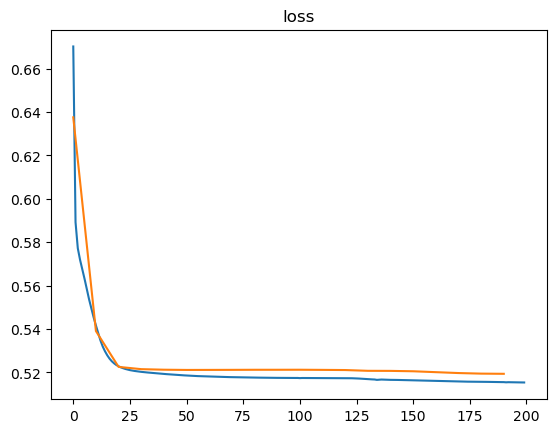

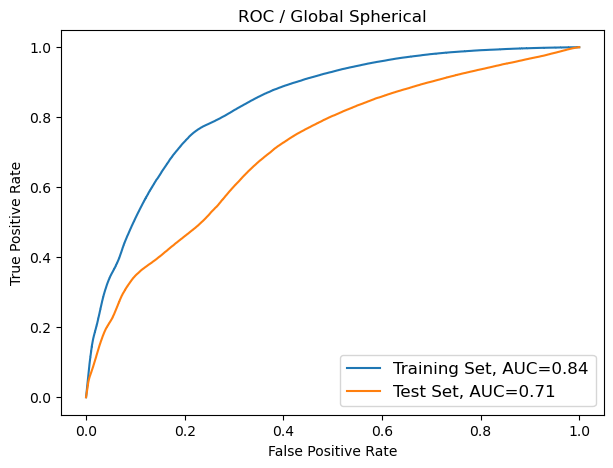

In [3]:
# One-Celler

import os
from time import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
import random


seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
np.random.seed(seed) # Numpy module.
random.seed(seed) # Python random module.
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True



# use GPUs if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA Available", device)
else:
    device = torch.device('cpu')
    print('CUDA Not Available', device)
# One liner:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Load Data & Graph
def load_data(i, f, local=False, spherical=True):
    dataset = []
    if not local: Xlist, ylist, edgelist = [], [], []
    
    for num in np.arange(i,f):
        df_sphere = pd.read_csv(f'/data1/dhhyun/DM100/df_DM{num:02}.csv', index_col=0)
        edge_index = np.genfromtxt(f'/data1/dhhyun/DM100/DM{num:02}_graph_k10.csv', delimiter=',', dtype='int')
        edge_index = torch.tensor(edge_index, dtype=torch.long)
        edge_index = edge_index.t().contiguous()

        if local:
            if spherical:
                X = np.column_stack((df_sphere['r'], df_sphere['theta'], df_sphere['phi'],
                    df_sphere['v_r'], df_sphere['v_theta'], df_sphere['v_phi']))
            else:
                X = np.column_stack((df_sphere['lx'], df_sphere['ly'], df_sphere['lz'],
                    df_sphere['vx'], df_sphere['vy'], df_sphere['vz']))
            y = np.array(df_sphere['flag']) # 1 for bound. #0 < #1
            
            # Normalization
            scaler = MinMaxScaler() # axis=0 default
            scaler.fit(X) 
            X = scaler.transform(X)
            
            # Data Object
            X = torch.tensor(X, dtype=torch.float)
            y = torch.tensor(y, dtype=torch.float) # not int32 #################### originally torch.long for class identification
            data = Data(x=X, edge_index=edge_index, y=y)
                        # train_mask=train_mask, test_mask=test_mask) # below
            dataset.append(data)
            
        elif not local:
            if spherical:
                X = np.column_stack((df_sphere['gr'], df_sphere['gtheta'], df_sphere['gphi'],
                    df_sphere['gv_r'], df_sphere['gv_theta'], df_sphere['gv_phi']))
            else:
                X = np.column_stack((df_sphere['x'], df_sphere['y'], df_sphere['z'],
                    df_sphere['vx'], df_sphere['vy'], df_sphere['vz']))
            y = np.array(df_sphere['flag']) # 1 for bound. #0 < #1
            Xlist.append(X)
            ylist.append(y)
            edgelist.append(edge_index)
            
    # Global Scaling
    if not local: 
        X_train = np.concatenate(Xlist[0::2], axis=0)
        X_test = np.concatenate(Xlist[1::2], axis=0)
        
        # Normalization
        scaler1 = MinMaxScaler() # axis=0 default
        scaler1.fit(X_train) 
        scaler2 = MinMaxScaler()
        scaler2.fit(X_test) 
        
        for index, (X, y, edge_index) in enumerate(zip(Xlist, ylist, edgelist)):
            if index%2==0:
                X = scaler1.transform(X)
            else:
                X = scaler2.transform(X)
                
            # Data Object
            X = torch.tensor(X, dtype=torch.float)
            y = torch.tensor(y, dtype=torch.float) # not int32 ### originally torch.long for class identification
            data = Data(x=X, edge_index=edge_index, y=y)
            dataset.append(data)
            
    return dataset[0::2], dataset[1::2] # training, test

train_dataset, test_dataset = load_data(0, 100, local=False, spherical=True)


# Train, Val, Test mask
# train_mask = np.zeros(len(y), dtype='int')
# num_samples = int(0.9 * len(y)) #later revise to be 8:1:1
# selected_indices = np.random.choice(train_mask, size=num_samples, replace=False)
# train_mask[selected_indices] = 1
# np.savetxt('/data1/dhhyun/train_mask.csv', train_mask, delimiter=',', fmt='%d')
# test_mask = torch.tensor(~train_mask, dtype=torch.bool)
# train_mask = torch.tensor(train_mask, dtype=torch.bool)

# trainloader = DataLoader(train_dataset, batch_size=1, shuffle=True) # batch_size=32


# GCN Layer
num_node_features = 6
num_hidden = 4

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, 6)
        self.conv2 = GCNConv(6, 4)
        self.conv3 = GCNConv(4, 1)
        # even number nodes are preferable

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # x = F.dropout(x, p=0.25, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        # x = F.dropout(x, training=self.training)
        
        x = self.conv3(x, edge_index)

        # return F.log_softmax(x, dim=1)
        
        m = torch.nn.Sigmoid()
        return m(x)


# Train
model = GCN().to(device)
# data = data.to(device)
criterion = torch.nn.BCELoss() ###############
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4) #####lr 0.01 -> 0.005
start = time()

loss_ = []
loss2_ = []
# n = len(trainloader) # for n batches
# n = 1
timesteps = 200

model.train()
for epoch in tqdm(range(timesteps)):
    running_loss = 0.0
    n = len(train_dataset)
    
    for data in train_dataset: #trainloader:
        data = data.to(device) ###########################################################
        optimizer.zero_grad()
        out = model(data)
        # loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        ###############
        # out_T = out[data.train_mask].t()[0]
        # loss = criterion(out_T, data.y[data.train_mask]) ###############
        # out_T = out.t()[0]
        out_T = out.squeeze() ########
        y_true = torch.tensor(data.y.clone().detach(), dtype=torch.float)
        loss = criterion(out_T, y_true)
        ##############
        loss.backward()
        optimizer.step()

        running_loss += loss.item() # for the case using trainloader inside a for loop
    loss_.append(running_loss/n) # MSE(Mean Squared Error)
    if epoch % 10 ==0:
        # with torch.no_grad():
        running_loss = 0.0
        for data in test_dataset: #trainloader:
            n = len(test_dataset)
            data = data.to(device) 
            out = model(data)
            out_T = out.squeeze()
            y_true = torch.tensor(data.y.clone().detach(), dtype=torch.float)
            loss = criterion(out_T, y_true)
            running_loss += loss.item() 
        loss2_.append(running_loss/n) # MSE(Mean Squared Error)
        
    
t = (time()-start)
print('total time', f'{t/60} min' if t>60 else f'{t} sec')



# Evaluation
with torch.no_grad():
    model.eval()
    # pred = model(data).argmax(dim=1)

    predlist = []
    for data in train_dataset:
        pred = model(data) #####################
        predlist.append(pred.cpu().detach().numpy())
    pred_train = np.concatenate(predlist)

    predlist = []
    for data in test_dataset:
        pred = model(data) #####################
        predlist.append(pred.cpu().detach().numpy())
    pred_test = np.concatenate(predlist)


pred_train_true = [d.y.cpu().detach().numpy() for d in train_dataset]
pred_train_true = np.concatenate(pred_train_true)

pred_test_true = [d.y.cpu().detach().numpy() for d in test_dataset]
pred_test_true = np.concatenate(pred_test_true)

# Export the result
# np.savetxt('/data1/dhhyun/DM100/loss_train.csv', loss_, delimiter=',')
# np.savetxt('/data1/dhhyun/DM100/loss_eval.csv', loss2_, delimiter=',')

# np.savetxt('/data1/dhhyun/DM100/pred_train.csv', pred_train, delimiter=',') #, fmt='%d')
# np.savetxt('/data1/dhhyun/DM100/pred_test.csv', pred_test, delimiter=',') #, fmt='%d')

# Visualization
plt.plot(np.arange(0,timesteps,1), loss_)
plt.plot(np.arange(0,timesteps,10), loss2_)
plt.title('loss')
plt.show()

fpr1, tpr1, _ = roc_curve(pred_train_true, pred_train)
fpr2, tpr2, _ = roc_curve(pred_test_true, pred_test)

auc1 = roc_auc_score(pred_train_true, pred_train)
auc2 = roc_auc_score(pred_test_true, pred_test)

fig, ax = plt.subplots(figsize=(7,5))#dpi=150)
RocCurveDisplay(fpr=fpr1, tpr=tpr1).plot(ax=ax, label=f'Training Set, AUC={auc1:.2f}')
RocCurveDisplay(fpr=fpr2, tpr=tpr2).plot(ax=ax, label=f'Test Set, AUC={auc2:.2f}')

plt.title('ROC / Global Spherical')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# ax.annotate(f'AUC (Training Set): {auc1:.2f}\nAUC (Test Set):      {auc2:.2f}', xy=(0.6,0.2), fontsize=12)
plt.legend(fontsize=12)
plt.show()

# Undersampling

In [42]:
# One-Celler, R-sphere 1kpc

import os
from time import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
import random


seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
np.random.seed(seed) # Numpy module.
random.seed(seed) # Python random module.
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True



# use GPUs if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA Available", device)
else:
    device = torch.device('cpu')
    print('CUDA Not Available', device)
# One liner:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Load Data & Graph
def load_data(i, f, local=False, spherical=True):
    dataset = []
    if not local: Xlist, ylist, edgelist = [], [], []
    
    for num in np.arange(i,f):
        df_sphere = pd.read_csv(f'/data1/dhhyun/DM100/df_DM{num:02}.csv', index_col=0)
        edge_index = np.genfromtxt(f'/data1/dhhyun/DM100/DM{num:02}_graph_R1kpc.csv', delimiter=',', dtype='int')
        edge_index = torch.tensor(edge_index, dtype=torch.long)
        edge_index = edge_index.t().contiguous()

        if local:
            if spherical:
                X = np.column_stack((df_sphere['r'], df_sphere['theta'], df_sphere['phi'],
                    df_sphere['v_r'], df_sphere['v_theta'], df_sphere['v_phi']))
            else:
                X = np.column_stack((df_sphere['lx'], df_sphere['ly'], df_sphere['lz'],
                    df_sphere['vx'], df_sphere['vy'], df_sphere['vz']))
            y = np.array(df_sphere['flag']) # 1 for bound. #0 < #1
            
            # Normalization
            scaler = MinMaxScaler() # axis=0 default
            scaler.fit(X) 
            X = scaler.transform(X)
            
            # Data Object
            X = torch.tensor(X, dtype=torch.float)
            y = torch.tensor(y, dtype=torch.float) # not int32 #################### originally torch.long for class identification
            data = Data(x=X, edge_index=edge_index, y=y)
                        # train_mask=train_mask, test_mask=test_mask) # below
            dataset.append(data)
            
        elif not local:
            if spherical:
                X = np.column_stack((df_sphere['gr'], df_sphere['gtheta'], df_sphere['gphi'],
                    df_sphere['gv_r'], df_sphere['gv_theta'], df_sphere['gv_phi']))
            else:
                X = np.column_stack((df_sphere['x'], df_sphere['y'], df_sphere['z'],
                    df_sphere['vx'], df_sphere['vy'], df_sphere['vz']))
            y = np.array(df_sphere['flag']) # 1 for bound. #0 < #1
            Xlist.append(X)
            ylist.append(y)
            edgelist.append(edge_index)
            
    # Global Scaling
    if not local: 
        X_train = np.concatenate(Xlist[0::2], axis=0)
        X_test = np.concatenate(Xlist[1::2], axis=0)
        
        # Normalization
        scaler1 = MinMaxScaler() # axis=0 default
        scaler1.fit(X_train) 
        scaler2 = MinMaxScaler()
        scaler2.fit(X_test) 
        
        for index, (X, y, edge_index) in enumerate(zip(Xlist, ylist, edgelist)):
            if index%2==0:
                X = scaler1.transform(X)
            else:
                X = scaler2.transform(X)
                
            # Data Object
            X = torch.tensor(X, dtype=torch.float)
            
            # UnderSampling
            indices_0 = np.where(y == 0)[0]
            indices_1 = np.where(y == 1)[0]
            if len(indices_0) < len(indices_1):
                print(index, 'bnd lesser than unbnd')
                selected_indices_1 = np.random.choice(indices_1, len(indices_0), replace=False)
                final_indices = np.concatenate([indices_0, selected_indices_1])
            else:
                selected_indices_0 = np.random.choice(indices_0, len(indices_1), replace=False)
                final_indices = np.concatenate([selected_indices_0, indices_1])
            train_mask = np.zeros(len(y))
            train_mask[final_indices] = 1
            train_mask = torch.tensor(train_mask, dtype=torch.bool)
            
            y = torch.tensor(y, dtype=torch.float) # not int32 ### originally torch.long for class identification
            data = Data(x=X, edge_index=edge_index, y=y, train_mask=train_mask)
            dataset.append(data)
            
    return dataset[0::2], dataset[1::2] # training, test

train_dataset, test_dataset = load_data(0, 100, local=False, spherical=True)



CUDA Not Available cpu
8 bnd lesser than unbnd
22 bnd lesser than unbnd
33 bnd lesser than unbnd
40 bnd lesser than unbnd
44 bnd lesser than unbnd
55 bnd lesser than unbnd
56 bnd lesser than unbnd


In [39]:
train_dataset[0]

Data(x=[11908, 6], edge_index=[2, 557427], y=[11908], train_mask=[11908])

In [40]:
test_dataset[0]

Data(x=[6542, 6], edge_index=[2, 258640], y=[6542], train_mask=[6542])

(array([ 9.,  9., 14., 10.,  9.,  7., 16.,  9.,  8.,  9.]),
 array([0.02238985, 0.11829168, 0.2141935 , 0.31009533, 0.40599715,
        0.50189898, 0.59780081, 0.69370263, 0.78960446, 0.88550628,
        0.98140811]),
 <BarContainer object of 10 artists>)

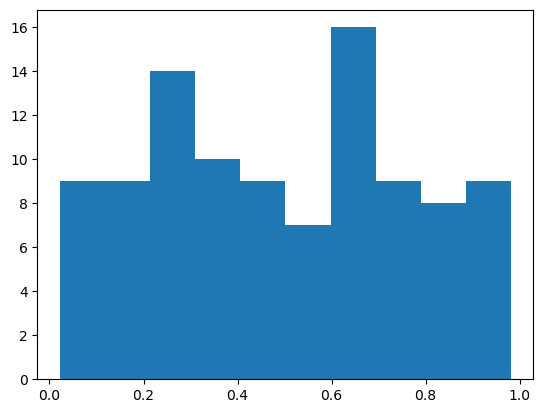

In [38]:
maskratio = [data.train_mask.cpu().detach().numpy().astype('int').sum()/len(data.train_mask) for data in train_dataset+test_dataset]
plt.hist(maskratio)

  0%|                                                                                           | 0/200 [00:00<?, ?it/s]/tmp/ipykernel_449988/683830702.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(data.y.clone().detach(), dtype=torch.float)
/tmp/ipykernel_449988/683830702.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(data.y.clone().detach(), dtype=torch.float)
100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [1:46:00<00:00, 31.80s/it]


total time 106.00563172896703 min


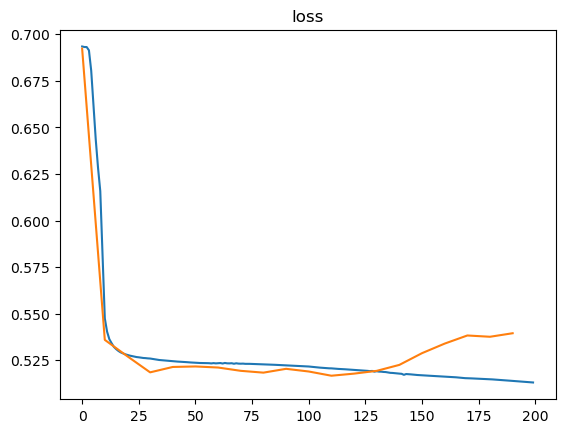

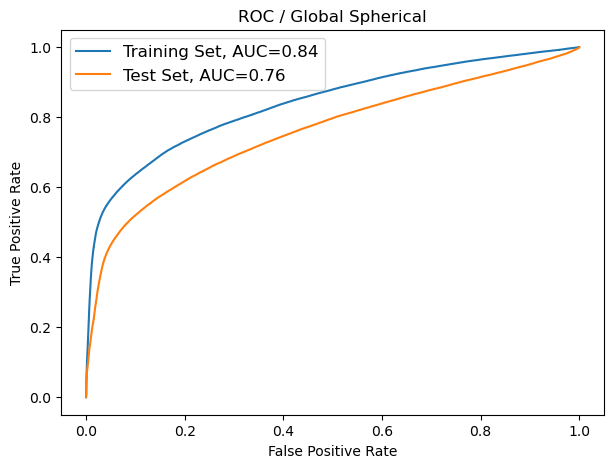

In [41]:
# Train, Val, Test mask
# train_mask = np.zeros(len(y), dtype='int')
# num_samples = int(0.9 * len(y)) #later revise to be 8:1:1
# selected_indices = np.random.choice(train_mask, size=num_samples, replace=False)
# train_mask[selected_indices] = 1
# np.savetxt('/data1/dhhyun/train_mask.csv', train_mask, delimiter=',', fmt='%d')
# test_mask = torch.tensor(~train_mask, dtype=torch.bool)
# train_mask = torch.tensor(train_mask, dtype=torch.bool)

# trainloader = DataLoader(train_dataset, batch_size=1, shuffle=True) # batch_size=32


# GCN Layer
num_node_features = 6
num_hidden = 4

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, 6)
        self.conv2 = GCNConv(6, 4)
        self.conv3 = GCNConv(4, 1)
        # even number nodes are preferable

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # x = F.dropout(x, p=0.25, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        # x = F.dropout(x, training=self.training)
        
        x = self.conv3(x, edge_index)

        # return F.log_softmax(x, dim=1)
        
        m = torch.nn.Sigmoid()
        return m(x)


# Train
model = GCN().to(device)
# data = data.to(device)
criterion = torch.nn.BCELoss() ###############
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4) #####lr 0.01 -> 0.005
start = time()

loss_ = []
loss2_ = []
# n = len(trainloader) # for n batches
# n = 1
timesteps = 200

model.train()
for epoch in tqdm(range(timesteps)):
    running_loss = 0.0
    n = len(train_dataset)
    
    for data in train_dataset: #trainloader:
        data = data.to(device) ###########################################################
        optimizer.zero_grad()
        out = model(data)
        # loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        ###############
        # out_T = out[data.train_mask].t()[0]
        # loss = criterion(out_T, data.y[data.train_mask]) ###############
        # out_T = out.t()[0]
        out_T = out.squeeze() ########
        y_true = torch.tensor(data.y.clone().detach(), dtype=torch.float)
        loss = criterion(out_T[data.train_mask], y_true[data.train_mask])
        ##############
        loss.backward()
        optimizer.step()

        running_loss += loss.item() # for the case using trainloader inside a for loop
    loss_.append(running_loss/n) # MSE(Mean Squared Error)
    if epoch % 10 ==0:
        # with torch.no_grad():
        running_loss = 0.0
        for data in test_dataset: #trainloader:
            n = len(test_dataset)
            data = data.to(device) 
            out = model(data)
            out_T = out.squeeze()
            y_true = torch.tensor(data.y.clone().detach(), dtype=torch.float)
            loss = criterion(out_T, y_true)
            running_loss += loss.item() 
        loss2_.append(running_loss/n) # MSE(Mean Squared Error)
        
    
t = (time()-start)
print('total time', f'{t/60} min' if t>60 else f'{t} sec')



# Evaluation
with torch.no_grad():
    model.eval()
    # pred = model(data).argmax(dim=1)

    predlist = []
    for data in train_dataset:
        pred = model(data) #####################
        predlist.append(pred.cpu().detach().numpy())
    pred_train = np.concatenate(predlist)

    predlist = []
    for data in test_dataset:
        pred = model(data) #####################
        predlist.append(pred.cpu().detach().numpy())
    pred_test = np.concatenate(predlist)


pred_train_true = [d.y.cpu().detach().numpy() for d in train_dataset]
pred_train_true = np.concatenate(pred_train_true)

pred_test_true = [d.y.cpu().detach().numpy() for d in test_dataset]
pred_test_true = np.concatenate(pred_test_true)

# Export the result
# np.savetxt('/data1/dhhyun/DM100/loss_train.csv', loss_, delimiter=',')
# np.savetxt('/data1/dhhyun/DM100/loss_eval.csv', loss2_, delimiter=',')

# np.savetxt('/data1/dhhyun/DM100/pred_train.csv', pred_train, delimiter=',') #, fmt='%d')
# np.savetxt('/data1/dhhyun/DM100/pred_test.csv', pred_test, delimiter=',') #, fmt='%d')

# Visualization
plt.plot(np.arange(0,timesteps,1), loss_)
plt.plot(np.arange(0,timesteps,10), loss2_)
plt.title('loss')
plt.show()

fpr1, tpr1, _ = roc_curve(pred_train_true, pred_train)
fpr2, tpr2, _ = roc_curve(pred_test_true, pred_test)

auc1 = roc_auc_score(pred_train_true, pred_train)
auc2 = roc_auc_score(pred_test_true, pred_test)

fig, ax = plt.subplots(figsize=(7,5))#dpi=150)
RocCurveDisplay(fpr=fpr1, tpr=tpr1).plot(ax=ax, label=f'Training Set, AUC={auc1:.2f}')
RocCurveDisplay(fpr=fpr2, tpr=tpr2).plot(ax=ax, label=f'Test Set, AUC={auc2:.2f}')

plt.title('ROC / Global Spherical')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# ax.annotate(f'AUC (Training Set): {auc1:.2f}\nAUC (Test Set):      {auc2:.2f}', xy=(0.6,0.2), fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [ ]:

# selected_indices = np.random.choice(train_mask, size=num_samples, replace=False)

Text(0.5, 1.0, 'UNBOUND Undersampled')

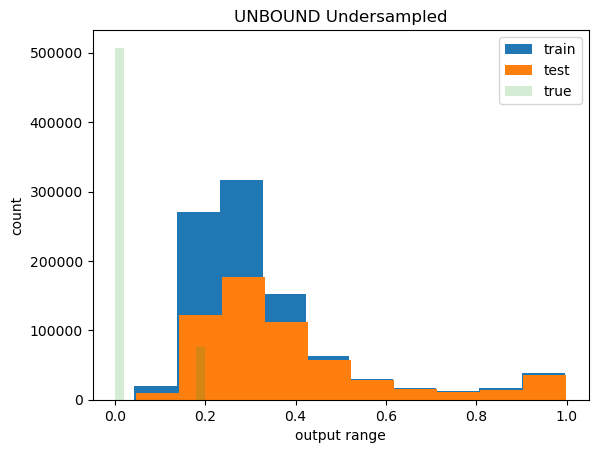

In [60]:
plt.hist(pred_train, label='train')
plt.hist(pred_test, label='test')
plt.hist(np.random.choice(np.concatenate((pred_train_true,pred_test_true)), size=len(pred_test))*0.2, alpha=.2, label='true')
plt.legend()

plt.xlabel('output range')
plt.ylabel('count')
plt.title('UNBOUND Undersampled')

Text(0.5, 1.0, 'UNBOUND Undersampled')

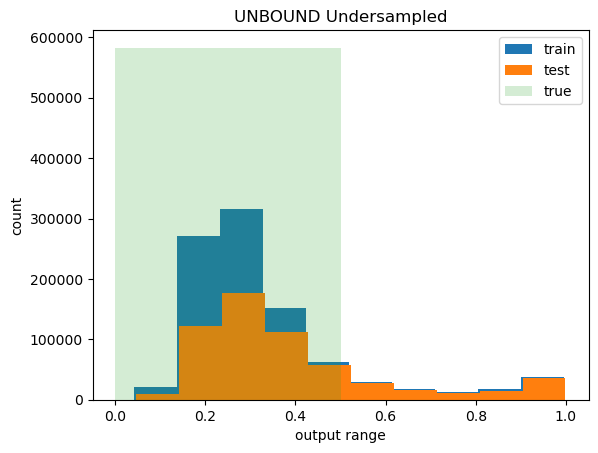

In [61]:
plt.hist(pred_train, label='train')
plt.hist(pred_test, label='test')
plt.hist(np.random.choice(np.concatenate((pred_train_true,pred_test_true)), size=len(pred_test))*0.2, bins=[0,.5,1], alpha=.2, label='true')
plt.legend()

plt.xlabel('output range')
plt.ylabel('count')
plt.title('UNBOUND Undersampled')

Text(0.5, 1.0, 'UNBOUND Undersampled')

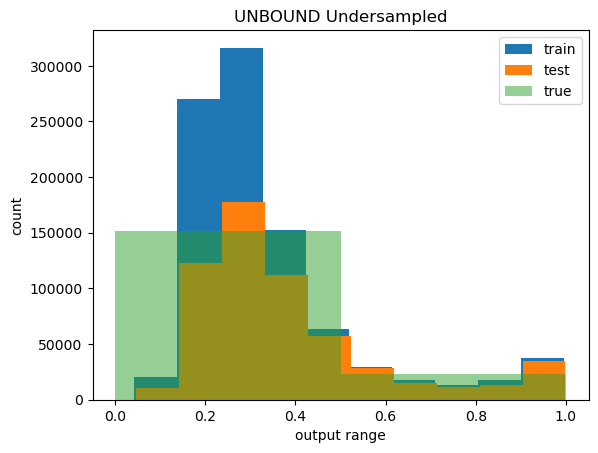

In [71]:
plt.hist(pred_train, label='train')
plt.hist(pred_test, label='test')
plt.hist(np.random.choice(np.concatenate((pred_train_true,pred_test_true)), size=int(len(pred_test)*0.3)), bins=[0,.5,1], alpha=.5, label='true')
plt.legend()

plt.xlabel('output range')
plt.ylabel('count')
plt.title('UNBOUND Undersampled')

## Radbin

In [47]:
%timeit
rblist = [np.genfromtxt(f'/data1/dhhyun/DM100/radbins{num:02}.csv', delimiter=',', dtype='int') for num in np.arange(0,100)]
radbin_train = np.concatenate(rblist[0::2])
radbin_test = np.concatenate(rblist[1::2])

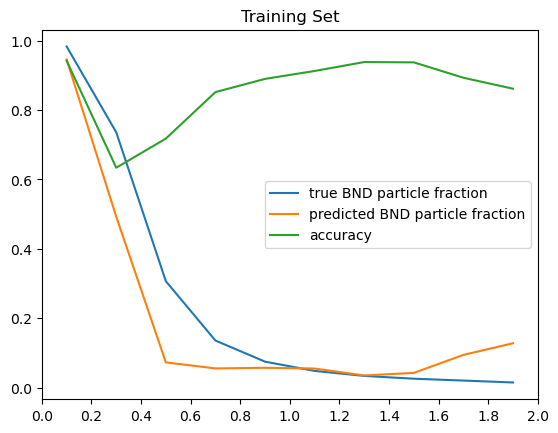

In [48]:
thresh = 0.5
sigfrac = [pred_train_true[radbin_train == i].sum()/len(pred_train_true[radbin_train == i]) for i in range(1,11)]
acc = [(np.digitize(pred_train[radbin_train == i].squeeze(), [thresh]) == pred_train_true[radbin_train == i]).astype('int').sum() / len(pred_train[radbin_train == i]) for i in range(1,11)]
sigfrac_pred = [np.digitize(pred_train[radbin_train == i].squeeze(), [thresh]).sum() / len(pred_train[radbin_train == i]) for i in range(1,11)]
plt.plot(np.arange(0.5,10.5)/5, sigfrac, label='true BND particle fraction')
plt.plot(np.arange(0.5,10.5)/5, sigfrac_pred, label='predicted BND particle fraction')
plt.plot(np.arange(0.5,10.5)/5, acc, label='accuracy')
plt.xticks(np.linspace(0,2,11))
plt.title('Training Set')
plt.legend()

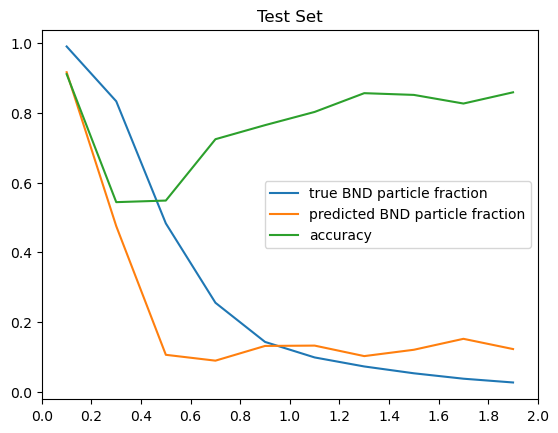

In [49]:
thresh = 0.5
sigfrac = [pred_test_true[radbin_test == i].sum()/len(pred_test_true[radbin_test == i]) for i in range(1,11)]
acc = [(np.digitize(pred_test[radbin_test == i].squeeze(), [thresh]) == pred_test_true[radbin_test == i]).astype('int').sum() / len(pred_test[radbin_test == i]) for i in range(1,11)]
sigfrac_pred = [np.digitize(pred_test[radbin_test == i].squeeze(), [thresh]).sum() / len(pred_test[radbin_test == i]) for i in range(1,11)]
plt.plot(np.arange(0.5,10.5)/5, sigfrac, label='true BND particle fraction')
plt.plot(np.arange(0.5,10.5)/5, sigfrac_pred, label='predicted BND particle fraction')
plt.plot(np.arange(0.5,10.5)/5, acc, label='accuracy')
plt.xticks(np.linspace(0,2,11))
plt.title('Test Set')
plt.legend()